In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considére dans ce cas l'équation de transport lineaire avec diffusion non linéaire suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \frac{\partial}{\partial x}\left( \left( \mu + \frac{\tau_y}{\sqrt{\epsilon^2 + \partial_x u}} \right) \frac{\partial u}{\partial x} \right) \quad \text{pour} \quad t > 0, \quad x \in [l, L] \\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [12]:
" **** Solutions initiales proposées **** "

@njit#(cache=True)
def u0_Creno(x):
    # Fonction indicatrice pour une condition initiale creno
    if  x >= 0.1 and x <= 0.2:
        return 10.
    else:
        return 0.

@njit#(cache=True)
def u0_Gauss(x,N):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin((N-1) * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "

@njit#(cache=True)
def F(u, a):
    # Flux exact
    return a * u


" **** Les flux numériques proposés **** "

@njit#(cache=True)
def Rusanov(ug, ud, a, dx, dt):
    # Flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a)) - a * (ud - ug)

@njit#(cache=True)
def Rusanov2(ug, ud, a, dx, dt):
    # Deuxième version du flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a) - a * (ud - ug))

@njit#(cache=True)
def Roe(ug, ud, a, dx, dt):
    # Flux numérique Roe
    if a >= 0:
        return F(ug, a)
    else:
        return F(ud, a)

@njit#(cache=True)
def LF(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * (F(ug, a) + F(ud, a) - (dx / dt) * (ud - ug))

@njit#(cache=True)
def LFM(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * (F(ug, a) + F(ud, a) - 0.5 * (dx / dt) * (ud - ug))

@njit(cache=True)
def LW(ug, ud, a, dx, dt):
    # Flux numérique Lax-Wendroff
    return 0.5 * (F(ug, a) + F(ud, a) - (dt / dx) * (a ** 2) * (ud - ug))

@njit#(cache=True)
def VFD(ug, ud, a, dx, dt):
    # Flux numérique volume finis decentré
    if a > 0:
        return F(ug, a)
    else:
        return F(ud, a)
    
    
@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,a):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        x1=xmp-dt*alpha*a
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha,a):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  a)

    up   = np.interp(x_car, x, u)
    

    return a * up



@njit(cache=True)
def VFC(U0, T,  N, a, alpha, dx, CFL,X, mu , tau):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**2)
        
        Diff = np.array([mu+tau/(np.sqrt(epsilon**2+absolute_differences[i])) for i in range(N-1)])
        
        max_diff = np.max(Diff)
        
        #dt  = CFL * dx / (a**2 * alpha) * np.abs(0.5*a-1/dx * max_diff)
        #dt  = CFL /(a/dx + 2 * np.abs(max_diff)/(dx**2))
        dt1  = CFL * (dx/(np.abs(a)*np.sqrt(2*alpha)))
        dt2  = CFL * 0.5 * dx**2 / np.abs(max_diff)
        dt   = min(dt1,dt2)
        
        
        temps += min(dt,T-dt)
        
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha,a)
            Fd  = fvc_flux(u2,X2,dt,alpha,a)
            
            FDd = (mu+tau/(np.sqrt(epsilon**2+((Un[i+1]-Un[i])/dx)**2))) * (Un[i+1]-Un[i])/dx
            FDg = (mu+tau/(np.sqrt(epsilon**2+((Un[i]-Un[i-1])/dx)**2))) * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) +  dt/dx * (FDd-FDg)
            
        Unp1[0]   = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        
        Un[:] = Unp1[:]
    return Un


@njit
def Solver(U0, a, epsilon, T,  N, CFL, scheme, mu, tau):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LW
    elif scheme == 4:
        flux = VFD
    
        
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**2)
        
        Diff = np.array([mu+tau/(np.sqrt(epsilon**2+absolute_differences[i])) for i in range(N)])
        
        max_diff = np.max(Diff)
        
        if scheme == 0 or scheme == 2 or scheme == 4:
            dt  = CFL /(a/dx + 2 * np.abs(max_diff)/(dx**2))
            
        if scheme == 1:
            dt  = CFL/(a/dx +  np.abs(max_diff)/(dx**2))
           
        if scheme == 3:
            dt  = CFL /(a/dx + 2 * np.abs(max_diff)/(dx**2))
        
        
        dt = min(dt, T - temps)
        temps += dt
        
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],a ,dx,dt)
            Fg = flux(Un[i-1],Un[i],a ,dx,dt)
            FDd = (mu+tau/(np.sqrt(epsilon**2+((Un[i+1]-Un[i])/dx)**2))) * (Un[i+1]-Un[i])/dx
            FDg = (mu+tau/(np.sqrt(epsilon**2+((Un[i]-Un[i-1])/dx)**2))) * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) +  dt/dx * (FDd-FDg)
            
            
        Unp1[0] = 0 #Unp1[1]
        Unp1[N-1] = 0 #Unp1[N-2]


        Un[:] = Unp1[:]
        

    return Un




##############################################################################################################
T        =   1/8
l        =   0
L        =   1
a        =   2
epsilon  =   1e-3
N        =   101
CFL      =   1/2
CFL2     =   1
alpha    =   1/2
X        =   np.linspace(l,L,N)
U0       =   np.array([u0_Creno(x) for x in X]) 
tau      =   1
mu       =   1e-3

dx = (L - l) / (N - 1)




" **** Calcul des solutions approchées **** "

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):0, ("LW",3):0,("LFM",4):0 }

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0, a, epsilon, T, N, CFL, i[1], mu, tau)   
    
#U_VFC = VFC( U0, T,  N, a, alpha, dx, CFL2, X, mu , tau)

#f['VFC'] = U_VFC

/tmp/ipykernel_8447/2065602964.py:188: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


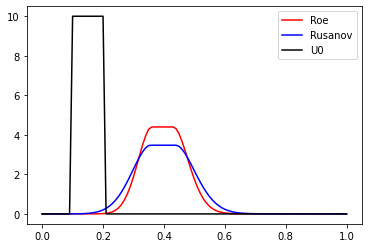

In [13]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":1, "LW":1, "LFM":1, "VFC":1}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    


#plt.xlim([1, 1.75])  
#plt.ylim([6, 12]) 

if epsilon == 0 :
    Uexact = np.array([Uex(T,x) for x in X])
    plt.plot(X, Uexact, '-k',  label='Uex')
else:
    plt.plot(X, U0, '-k',  label='U0')
    
#plt.xlim([-0.05, 2])  
#plt.ylim([0.6, 0.9])  

plt.legend()
plt.pause(0.1)



In [11]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm


{'Roe': 22.859230248602888, 'Rusanov': 22.859230543136082}